In [6]:
pip install streamlit hdbscan numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [8]:
df = pd.read_csv("final_merged_df.csv")
df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,6.410498,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,6.410498,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,6.410498,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,6.410498,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,6.410498,1.0,Turkana


In [9]:
missing_values = df.isnull().sum()
missing_values

Latitude               0
Longitude              0
Pop_Density_2000       0
Pop_Density_2001       0
Pop_Density_2002       0
Pop_Density_2003       0
Pop_Density_2004       0
Pop_Density_2005       0
Pop_Density_2006       0
Pop_Density_2007       0
Pop_Density_2008       0
Pop_Density_2009       0
Pop_Density_2010       0
Pop_Density_2011       0
Pop_Density_2012       0
Pop_Density_2013       0
Pop_Density_2014       0
Pop_Density_2015       0
Pop_Density_2016       0
Pop_Density_2017       0
Pop_Density_2018       0
Pop_Density_2019       0
Pop_Density_2020       0
Wind_Speed             0
Grid_Value             0
Income_Distribution    0
dtype: int64

## **HDBSCAN**

### **Identify regions with sparse development where extending the grid is inefficient but wind microgrids could be feasible.**

* Since HDBSCAN is a density-based algorithm,the clustering approach effectively groups areas based on density and other characteristics.
* These clusters help indicate areas where extending the main grid might be inefficient, making them candidates for decentralized energy solutions, like wind or solar microgrids.
* This algorithm is valuable for identifying potential zones for alternative energy solutions based on current density and infrastructure access patterns.

In [10]:
# One-hot encode 'Income_Distribution' if it's categorical
df = pd.get_dummies(df, columns=['Income_Distribution'], prefix='Income')

In [11]:
# The one-hot encoded columns starting with "Income_"should be included
income_columns = [col for col in df.columns if col.startswith('Income_')]
clustering_data = df[['Pop_Density_2020', 'Wind_Speed', 'Latitude', 'Longitude', 'Grid_Value'] + income_columns]

In [12]:
# Standardize the data to bring all features to a similar scale
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

In [13]:
# Apply PCA to reduce to a manageable number of components
pca = PCA(n_components=2)  # Adjust to 2 components for efficient clustering
clustering_data_reduced = pca.fit_transform(clustering_data_scaled)

In [14]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusters = clusterer.fit_predict(clustering_data_reduced)
stability_scores = clusterer.probabilities_

In [15]:
# Add clusters and stability scores back to the original DataFrame
df['Cluster'] = clusters
df['Stability_Score'] = stability_scores

In [16]:
# Apply HDBSCAN with optimized parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50)  # Adjust min_samples and min_cluster_size as needed
clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)

In [17]:
# Filter out noise points (-1 label in HDBSCAN) before calculating metrics
clustered_data = clustering_data_reduced[clusters != -1]
valid_clusters = clusters[clusters != -1]

In [18]:
# Access cluster stability scores from HDBSCAN
stability_scores = hdbscan_clusterer.probabilities_

In [19]:
if len(set(valid_clusters)) > 1:  # Ensure there's more than one cluster for evaluation
    db_index = davies_bouldin_score(clustered_data, valid_clusters)
    ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
    print("Davies-Bouldin Index:", db_index)
    print("Calinski-Harabasz Index:", ch_index)
else:
    print("Insufficient clusters for evaluation metrics")

# Print stability scores and cluster labels
print("Cluster Labels:", clusters)
print("Cluster Stability Scores:", stability_scores)

Davies-Bouldin Index: 0.8569168532461975
Calinski-Harabasz Index: 531677.3357841002
Cluster Labels: [1579 1579 1579 ...  324  814  814]
Cluster Stability Scores: [0.64430244 0.97115327 1.         ... 0.05132844 0.84816119 0.84816119]


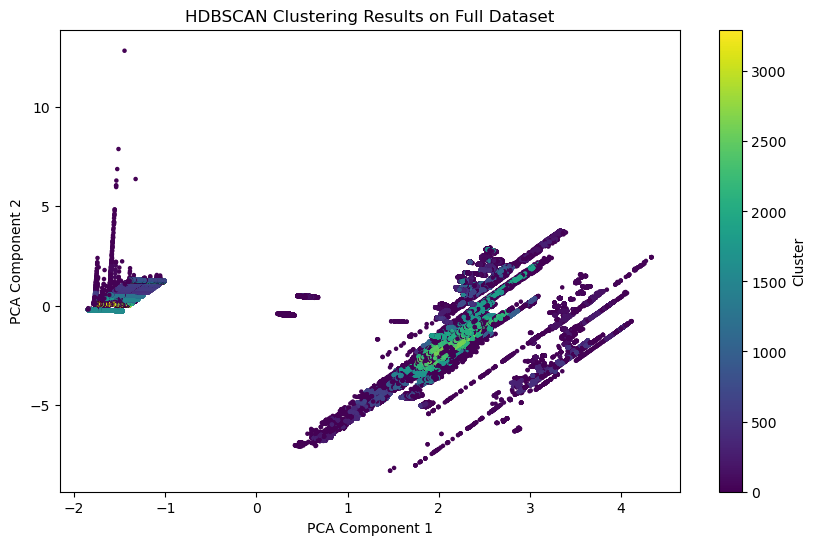

In [20]:
# Visualize clustering results
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data_reduced[:, 0], clustering_data_reduced[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('HDBSCAN Clustering Results on Full Dataset')
plt.show()

In [21]:
import joblib

# Save the scaler, PCA, and HDBSCAN model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(hdbscan_clusterer, 'hdbscan_model.pkl')

['hdbscan_model.pkl']